In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2022-06-19 12:50:47.126658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-19 12:50:47.126679: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
batch_size = 32
img_height = 180
img_width = 180

In [3]:
data_dir = "Pistachio_Image_Dataset_Train"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1933 files belonging to 2 classes.
Using 1547 files for training.


2022-06-19 12:50:49.991568: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-19 12:50:49.991589: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-19 12:50:49.991606: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alexandre-H310M-M-2-2-0): /proc/driver/nvidia/version does not exist
2022-06-19 12:50:49.993114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
data_dir = "Pistachio_Image_Dataset_Train"
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1933 files belonging to 2 classes.
Using 386 files for validation.


In [5]:
data_dir = "Pistachio_Image_Dataset_Test"
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 215 files belonging to 2 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Kirmizi_Pistachio', 'Siirt_Pistachio']


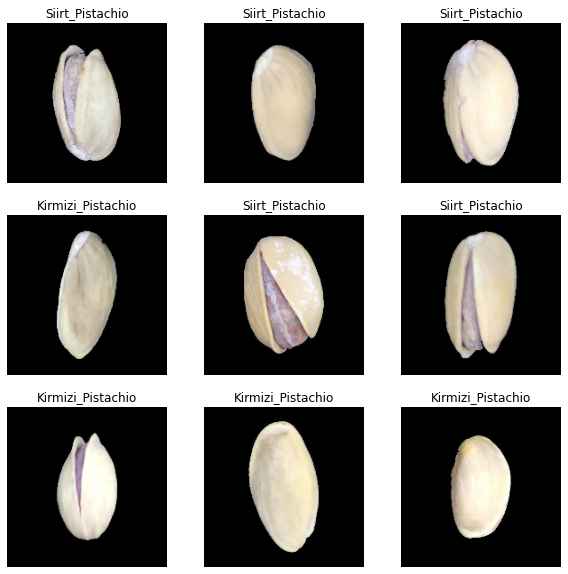

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

(32, 180, 180, 3)
(32,)


In [9]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.97614473


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
49/49 [==============================] - 20s 402ms/step - loss: 0.4790 - accuracy: 0.7473 - val_loss: 0.4540 - val_accuracy: 0.8005
Epoch 2/10
49/49 [==============================] - 19s 397ms/step - loss: 0.3609 - accuracy: 0.8371 - val_loss: 0.4212 - val_accuracy: 0.8212
Epoch 3/10
49/49 [==============================] - 19s 397ms/step - loss: 0.3282 - accuracy: 0.8584 - val_loss: 0.3809 - val_accuracy: 0.8290
Epoch 4/10
49/49 [==============================] - 19s 394ms/step - loss: 0.2783 - accuracy: 0.8856 - val_loss: 0.4257 - val_accuracy: 0.8264
Epoch 5/10
49/49 [==============================] - 19s 395ms/step - loss: 0.2479 - accuracy: 0.8888 - val_loss: 0.4100 - val_accuracy: 0.8472
Epoch 6/10
49/49 [==============================] - 19s 396ms/step - loss: 0.2135 - accuracy: 0.9121 - val_loss: 0.4141 - val_accuracy: 0.8575
Epoch 7/10
49/49 [==============================] - 19s 397ms/step - loss: 0.1900 - accuracy: 0.9250 - val_loss: 0.3865 - val_accuracy: 0.8575

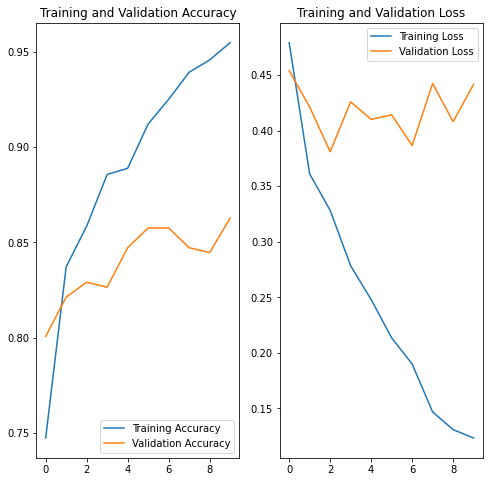

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_curve

teste = []
for _, label in test_ds:
    for a in label:
        teste.append(a.numpy())
y_test = np.array(teste)

pred = model.predict(test_ds)
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, pred)
# tpr_keras = -np.sort(-tpr_keras)

# from sklearn.metrics import auc
# auc_keras = auc(fpr_keras, tpr_keras)

7/7 [==============================] - 1s 77ms/step


In [22]:
pred

array([[-5.2721415 ,  2.702126  ],
       [ 4.425925  , -3.900769  ],
       [ 6.8142567 , -6.2952814 ],
       [ 3.3413208 , -2.9619045 ],
       [ 5.450892  , -4.721303  ],
       [ 4.048204  , -3.8397596 ],
       [-0.80803895,  0.9856664 ],
       [-0.27674046, -0.29703337],
       [ 0.26261756, -0.8681522 ],
       [ 0.08342298, -0.2526338 ],
       [-6.157659  ,  4.9373984 ],
       [-4.3641324 ,  3.6225402 ],
       [-2.492634  ,  1.7588062 ],
       [ 2.9276125 , -3.5172417 ],
       [ 0.697345  , -1.252016  ],
       [ 5.1764293 , -4.9406524 ],
       [ 0.7226798 , -1.0513985 ],
       [-6.071734  ,  4.394496  ],
       [-2.734105  ,  2.4167664 ],
       [ 5.175134  , -5.434109  ],
       [-4.85729   ,  6.1212583 ],
       [ 2.8554852 , -2.7994778 ],
       [ 0.661915  , -1.0236372 ],
       [ 4.9998918 , -4.7649727 ],
       [ 6.1163964 , -5.675336  ],
       [ 5.634606  , -5.4975686 ],
       [-0.2407311 , -0.60201764],
       [-5.1705604 ,  2.9688232 ],
       [ 3.5311418 ,

In [11]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

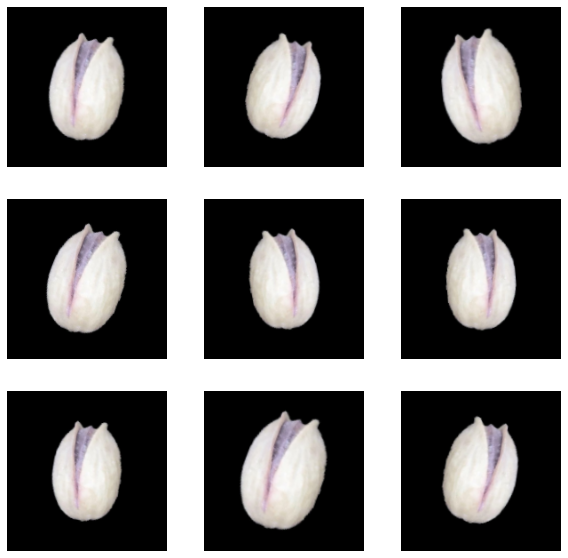

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [13]:
model = Sequential()
model.add(data_augmentation)
model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(16, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.2))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [14]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [16]:
best_model = tf.keras.callbacks.ModelCheckpoint(
    "model_best",
    monitor="val_loss",
    save_best_only=True,
)

In [28]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[best_model]
)

Epoch 1/20
49/49 [==============================] - 22s 444ms/step - loss: 0.4186 - accuracy: 0.8119 - val_loss: 0.4548 - val_accuracy: 0.7953
Epoch 2/20
49/49 [==============================] - 22s 445ms/step - loss: 0.4328 - accuracy: 0.7996 - val_loss: 0.4542 - val_accuracy: 0.7876
Epoch 3/20
49/49 [==============================] - 22s 443ms/step - loss: 0.3979 - accuracy: 0.8203 - val_loss: 0.5369 - val_accuracy: 0.7409
Epoch 4/20
49/49 [==============================] - 22s 445ms/step - loss: 0.4058 - accuracy: 0.8177 - val_loss: 0.5162 - val_accuracy: 0.7642
Epoch 5/20
49/49 [==============================] - 22s 451ms/step - loss: 0.3778 - accuracy: 0.8300 - val_loss: 0.4543 - val_accuracy: 0.8031
Epoch 6/20
49/49 [==============================] - 22s 444ms/step - loss: 0.3790 - accuracy: 0.8242 - val_loss: 0.4691 - val_accuracy: 0.7927
Epoch 7/20
49/49 [==============================] - 22s 444ms/step - loss: 0.3777 - accuracy: 0.8235 - val_loss: 0.4424 - val_accuracy: 0.8031

INFO:tensorflow:Assets written to: model_best/assets


INFO:tensorflow:Assets written to: model_best/assets


49/49 [==============================] - 24s 491ms/step - loss: 0.3722 - accuracy: 0.8313 - val_loss: 0.4188 - val_accuracy: 0.8135
Epoch 9/20
49/49 [==============================] - 22s 442ms/step - loss: 0.3445 - accuracy: 0.8468 - val_loss: 0.4254 - val_accuracy: 0.8264
Epoch 10/20
49/49 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8494

INFO:tensorflow:Assets written to: model_best/assets


INFO:tensorflow:Assets written to: model_best/assets


49/49 [==============================] - 24s 481ms/step - loss: 0.3418 - accuracy: 0.8494 - val_loss: 0.3817 - val_accuracy: 0.8342
Epoch 11/20
49/49 [==============================] - 22s 450ms/step - loss: 0.3194 - accuracy: 0.8662 - val_loss: 0.3827 - val_accuracy: 0.8187
Epoch 12/20
49/49 [==============================] - 22s 447ms/step - loss: 0.2964 - accuracy: 0.8778 - val_loss: 0.5076 - val_accuracy: 0.8057
Epoch 13/20
49/49 [==============================] - ETA: 0s - loss: 0.2911 - accuracy: 0.8765

INFO:tensorflow:Assets written to: model_best/assets


INFO:tensorflow:Assets written to: model_best/assets


49/49 [==============================] - 24s 483ms/step - loss: 0.2911 - accuracy: 0.8765 - val_loss: 0.3075 - val_accuracy: 0.8860
Epoch 14/20
49/49 [==============================] - 22s 444ms/step - loss: 0.2767 - accuracy: 0.8888 - val_loss: 0.3518 - val_accuracy: 0.8627
Epoch 15/20
49/49 [==============================] - 22s 445ms/step - loss: 0.2809 - accuracy: 0.8798 - val_loss: 0.3078 - val_accuracy: 0.8886
Epoch 16/20
49/49 [==============================] - ETA: 0s - loss: 0.2453 - accuracy: 0.8933

INFO:tensorflow:Assets written to: model_best/assets


INFO:tensorflow:Assets written to: model_best/assets


49/49 [==============================] - 24s 488ms/step - loss: 0.2453 - accuracy: 0.8933 - val_loss: 0.2875 - val_accuracy: 0.8756
Epoch 17/20
49/49 [==============================] - 22s 443ms/step - loss: 0.2337 - accuracy: 0.9030 - val_loss: 0.3586 - val_accuracy: 0.8446
Epoch 18/20
49/49 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.8953

INFO:tensorflow:Assets written to: model_best/assets


INFO:tensorflow:Assets written to: model_best/assets


49/49 [==============================] - 24s 482ms/step - loss: 0.2639 - accuracy: 0.8953 - val_loss: 0.2642 - val_accuracy: 0.8964
Epoch 19/20
49/49 [==============================] - 22s 456ms/step - loss: 0.2438 - accuracy: 0.8966 - val_loss: 0.2752 - val_accuracy: 0.8964
Epoch 20/20
49/49 [==============================] - 22s 444ms/step - loss: 0.2180 - accuracy: 0.9127 - val_loss: 0.3143 - val_accuracy: 0.8705


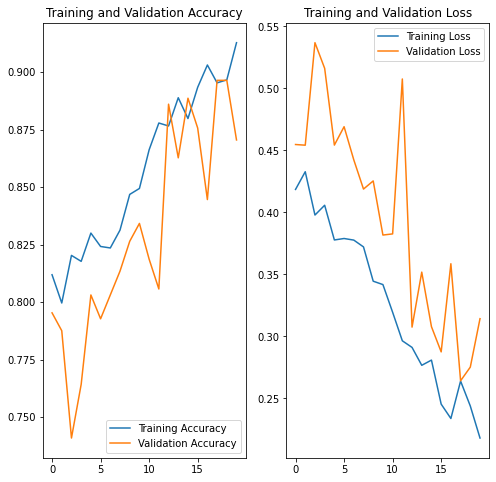

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_curve

teste = []
for _, label in test_ds:
    for a in label:
        teste.append(a.numpy())
y_test = np.array(teste)

pred = model.predict(test_ds)[:,0]
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, pred)
tpr_keras = -np.sort(-tpr_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

7/7 [==============================] - 1s 75ms/step


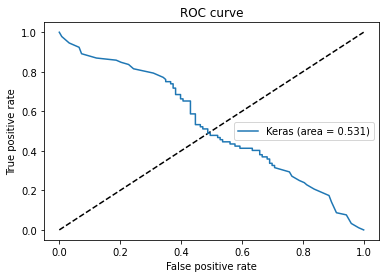

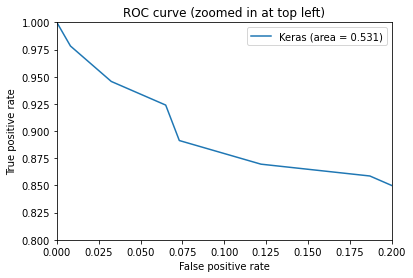

In [56]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [37]:
print(fpr_keras)

[0.         0.00813008 0.03252033 0.03252033 0.04878049 0.04878049
 0.05691057 0.05691057 0.07317073 0.07317073 0.08130081 0.08130081
 0.08943089 0.08943089 0.09756098 0.09756098 0.15447154 0.15447154
 0.16260163 0.16260163 0.17073171 0.17073171 0.21138211 0.21138211
 0.22764228 0.22764228 0.24390244 0.24390244 0.25203252 0.25203252
 0.26829268 0.26829268 0.27642276 0.27642276 0.28455285 0.28455285
 0.29268293 0.29268293 0.30894309 0.32520325 0.32520325 0.36585366
 0.36585366 0.38211382 0.38211382 0.39837398 0.39837398 0.41463415
 0.41463415 0.43089431 0.43089431 0.43902439 0.43902439 0.44715447
 0.44715447 0.45528455 0.45528455 0.4796748  0.4796748  0.49593496
 0.49593496 0.50406504 0.50406504 0.5203252  0.5203252  0.53658537
 0.55284553 0.55284553 0.56910569 0.56910569 0.58536585 0.58536585
 0.6097561  0.6097561  0.64227642 0.64227642 0.68292683 0.68292683
 0.70731707 0.70731707 0.7398374  0.7398374  0.76422764 0.76422764
 0.79674797 0.79674797 0.80487805 0.80487805 0.84552846 0.8455

In [53]:
fpr_keras = -np.sort(-fpr_keras)

In [39]:
thresholds_keras

array([1.9999912e+00, 9.9999112e-01, 9.9997133e-01, 9.9994522e-01,
       9.9989736e-01, 9.9988097e-01, 9.9987870e-01, 9.9986601e-01,
       9.9984431e-01, 9.9980593e-01, 9.9976277e-01, 9.9972999e-01,
       9.9969733e-01, 9.9938673e-01, 9.9915725e-01, 9.9888074e-01,
       9.9825019e-01, 9.9822605e-01, 9.9820095e-01, 9.9779403e-01,
       9.9776030e-01, 9.9774373e-01, 9.9712801e-01, 9.9704236e-01,
       9.9690938e-01, 9.9672562e-01, 9.9662501e-01, 9.9614966e-01,
       9.9611056e-01, 9.9580461e-01, 9.9540758e-01, 9.9530506e-01,
       9.9514157e-01, 9.9405169e-01, 9.9397850e-01, 9.9327213e-01,
       9.9284774e-01, 9.9276191e-01, 9.9202532e-01, 9.9176991e-01,
       9.9140906e-01, 9.9034017e-01, 9.8989999e-01, 9.8786634e-01,
       9.8725688e-01, 9.8681641e-01, 9.8487622e-01, 9.8454994e-01,
       9.8185921e-01, 9.7889113e-01, 9.7558272e-01, 9.7272432e-01,
       9.7271061e-01, 9.7202730e-01, 9.6743381e-01, 9.6689123e-01,
       9.6426332e-01, 9.4395036e-01, 9.4281578e-01, 9.3416309e

# tuto

In [66]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=80000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [68]:
from keras.models import Sequential
from keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(20, input_dim=20, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
keras_model.fit(X_train, y_train, epochs=5, batch_size=100, verbose=1)

Epoch 1/5
400/400 [==============================] - 1s 907us/step - loss: 0.2527 - accuracy: 0.8963
Epoch 2/5
400/400 [==============================] - 0s 1ms/step - loss: 0.1628 - accuracy: 0.9228
Epoch 3/5
400/400 [==============================] - 0s 1ms/step - loss: 0.1529 - accuracy: 0.9298
Epoch 4/5
400/400 [==============================] - 0s 1ms/step - loss: 0.1449 - accuracy: 0.9377
Epoch 5/5
400/400 [==============================] - 0s 1ms/step - loss: 0.1366 - accuracy: 0.9444


In [69]:
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

1250/1250 [==============================] - 1s 574us/step


In [74]:
y_pred_keras

array([0.98910767, 0.06940081, 0.00619172, ..., 0.48893714, 0.96412855,
       0.9917121 ], dtype=float32)

In [73]:
y_test

array([1, 0, 0, ..., 1, 1, 1])